# Usizo

Usizo is a project to help improve access to cheap credit to Africans in Sub-Saharan Africa. To do this, I aim to build an ML-based decision engine for extending credit. The first phase of this process, which I am doing in this notebook, is training a model to serve as a decision engine. This model will use publicly-available data to train a proof-of-concept model. If successful, then this project will be replicated using African data.

## Data
The data used in this task was obtained uploaded to OpenML by Dustin Carrion. The link to the dataset is here: https://www.openml.org/search?type=data&sort=runs&id=43454&status=active.

### Structure
The data contains the following columns:

- person_age (int): The age of the borrower
- person_income (int): How much the person makes annually in euros.
- person_home_ownership (enum): Either rent, own, mortgage, or
- person_emp_length (float): How long the persn has been employed (in years)
- loan_intent (enum): The intended purpose of the borrrowed funds.
- loan_grade (enum): The grade of the loan. This is better explained [here](https://www.thebalancemoney.com/what-is-loan-grading-5211003).
- loan_amnt (float): The amount borrowed.
- loan_int_rate (float): The loan interest rate.
- loan_status (enum): The present status of the loan where 0 means they have not defaulted and 1 means they have defaulted.
- loanpercentincome Percent income
- cb_person_default_on_file (enum): Either 0 or 1 where 1 means the borrower has defaulted on loans in the past and 0 means they have not.
- cb_preson_cred_hist_length (float): How long the person has been using credit in years.

### Quantity
There are 32,581 rows in the dataset which should be plenty enough for training.


# Step 0: Set Up Environment



## Step 0.1: Installing additional libraries
The data is stored using arff file format. `liac-arff` is a good library for reading .arff files.

In [1]:
!pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=9ccb8337c1465059a1c29ef15759f14abae0c00447d91584957b0c47b9b2a9f7
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


## Step 0.2: Importing required libraries

- NumPy for numerical processing
- Arff for reading the data
- Pandas for managing the data as a dataframe
- Tensorflow for building and training the model
- Sklearn for preprocessing and splitting the data
- Matplotlib and Seaborn for plotting diagrams

In [122]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arff
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score, precision_score, recall_score

# Step 1: Reading and Preprocessing the Data

During this step, I will read the data and prepare it for training. Preparations will include cleaning up the data, selecting the features and splitting the data into training and test data.

### Step 1.1: Reading the data

In [4]:
# Reading the data from ./credit_risk.arff
path_to_file = './credit_risk.arff'
arff_data = arff.load(open(path_to_file, 'r'))

# Setting columns as these were not preset in the data
df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])

# Printing the first few rows of the data
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


### Step 1.2: Inspecting the data

During this stage, I identified several issues with the data.

1. Two columns(`loan_int_rate` and `person_emp_length`) are missing values. I will fill these columns with mean values.

2. Certain age values are above 140. This is likely to be an error within the dataset. I'm going to drop all values above 90.


3. The target classes(`loan_status`) are imbalanced with over 80% of the values belonging to class 0(not default). To correct this, I will use oversampling.

In [5]:
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


## Step 1.3: Preprocessing the data

During this process, I did the following to prepare the data for training:
1. I cleaned the data by filtering rows that had ages above 90.
2. I encoded the data so that it is entirely numeric.
3. I filled missing values by the mean of that feature and class.
4. I oversampled the class 1 to balance the classes.
5. Explored features to identify the most relevant and selected them for training.

### Step 1.3.1: Filtering rows with age above 90

In [6]:
df = df[df['person_age'] < 90]
df.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32573.000000,3.257300e+04,31678.000000,32573.000000,29459.000000,32573.000000,32573.000000,32573.000000
mean,27.712676,6.588260e+04,4.789665,9589.285605,11.011642,0.218218,0.170213,5.802167
std,6.179754,5.253665e+04,4.142799,6322.135503,3.240666,0.413042,0.106780,4.049625
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,78.000000,2.039784e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


### Step 1.3.2: Encoding

In [8]:
person_home_ownership_encoder = LabelEncoder()
loan_intent_encoder = LabelEncoder()
cb_person_default_on_file_encoder = LabelEncoder()
loan_grade_encoder = LabelEncoder()

df['person_home_ownership'] = person_home_ownership_encoder.fit_transform(df['person_home_ownership'])
df['loan_intent'] = loan_intent_encoder.fit_transform(df['loan_intent'])
df['loan_grade'] = loan_grade_encoder.fit_transform(df['loan_grade'])
df['cb_person_default_on_file'] = cb_person_default_on_file_encoder.fit_transform(df['cb_person_default_on_file'])

df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,3,123.0,4,3,35000,16.02,1,0.59,1,3
1,21,9600,2,5.0,1,1,1000,11.14,0,0.10,0,2
2,25,9600,0,1.0,3,2,5500,12.87,1,0.57,0,3
3,23,65500,3,4.0,3,2,35000,15.23,1,0.53,0,2
4,24,54400,3,8.0,3,2,35000,14.27,1,0.55,1,4


### Step 1.3.3: Filling Missing values

In [11]:
class_means = df.groupby('loan_status').transform('mean')

df_filled = df.fillna(class_means)
df_filled.describe()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
count,32573.000000,3.257300e+04,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000,32573.000000
mean,27.712676,6.588260e+04,1.676174,4.787390,2.533663,1.218187,9589.285605,11.008477,0.218218,0.170213,0.176373,5.802167
std,6.179754,5.253665e+04,1.433107,4.086009,1.731203,1.166433,6322.135503,3.099356,0.413042,0.106780,0.381143,4.049625
min,20.000000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,500.000000,5.420000,0.000000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,0.000000,2.000000,1.000000,0.000000,5000.000000,8.490000,0.000000,0.090000,0.000000,3.000000
50%,26.000000,5.500000e+04,3.000000,4.000000,3.000000,1.000000,8000.000000,10.740000,0.000000,0.150000,0.000000,4.000000
75%,30.000000,7.920000e+04,3.000000,7.000000,4.000000,2.000000,12200.000000,13.110000,0.000000,0.230000,0.000000,8.000000
max,78.000000,2.039784e+06,3.000000,123.000000,5.000000,6.000000,35000.000000,23.220000,1.000000,0.830000,1.000000,30.000000


### Step 1.3.4: Balancing the classes

In [17]:
X_unbalanced = df_filled.drop('loan_status', axis=1, inplace=False)
y_unbalanced = df_filled['loan_status']

ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_unbalanced, y_unbalanced)

In [25]:
print("Number of Y:", y_balanced.shape[0])
print("Number of 1s in Y:", np.sum(y_balanced == 1))
print("Number of 0s in Y:", np.sum(y_balanced == 0))

Number of Y: 50930
Number of 1s in Y: 25465
Number of 0s in Y: 25465


### Step 1.3.5: Selecting features

Based on the heatmap shown below, the most features that indicate a strong correlation with the target(`loan_status`) are:
1. person_income
2. person_home_ownership
3. loan_grade
4. loan_amt
5. loan_int_rate
6. loan_percent_income
7. cb_person_default_on_file

Now consider the following,
1. loan_percent_income = loan_amt / person_income. Therefore if we consider only loan_percent_income, we would have considered both loan_amt and person_income.
2. loan_grade is strongly correlated with loan_int_rate. Which makes sense as loan_grade is based on perceived risk and the loan_int_rate is also based on the same perceived risk. Therefore it should suffice to use only one of those features. I will use loan_int_rate as it is more granular.

This leaves us with the following four features:
1. person_home_ownership
2. loan_int_rate
3. loan_percent_income
4. cb_person_default_on_file

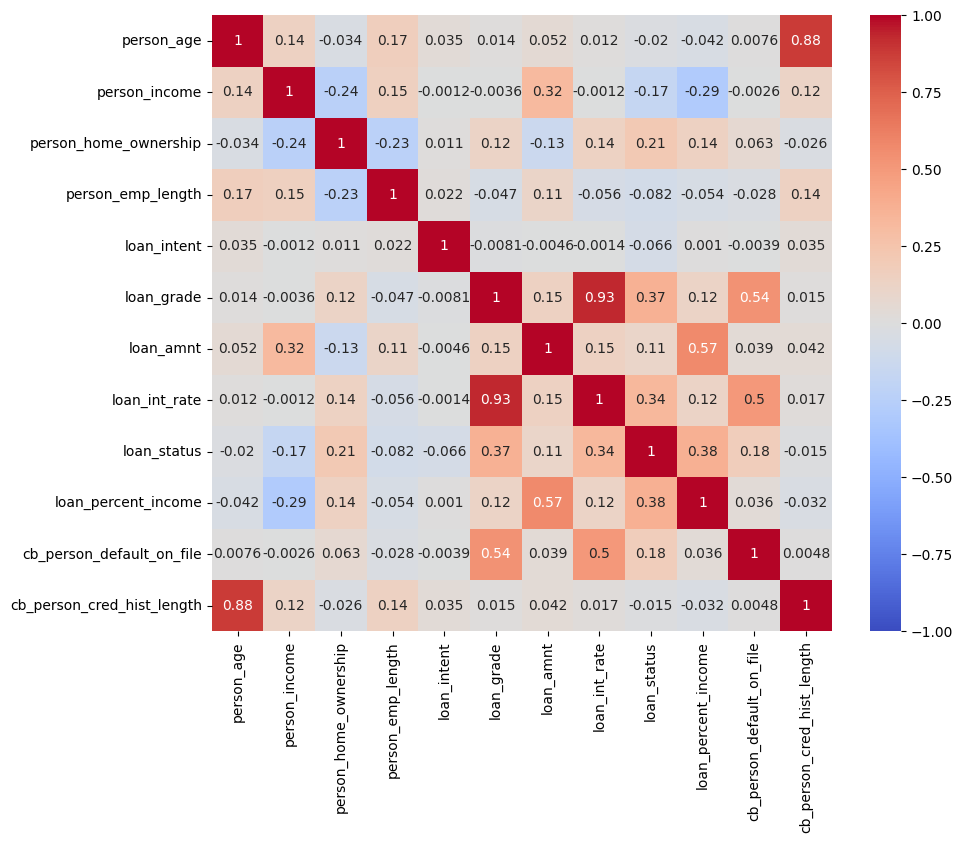

In [27]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.show()

In [28]:
X_features = ['person_home_ownership', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file']
Y_target = 'loan_status'
X = X_balanced[X_features]
y = y_balanced

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (40744, 4)
X_test shape: (10186, 4)
y_train shape: (40744,)
y_test shape: (10186,)


# Step 2: Building vanilla model

## Step 2.1: Defining the model architecture

I settled for the 16, 8, 1 model architecture. I started with the (8, 4, 1) and it produced an accuracy of around 74%. I experimented with a deeper network with more layers(32, 16, 8, 4, 1)) and accuracy dropped dramatically to 50%. I then experimented with a wider network (64, 16, 4, 1) but it did not perform better than the initial (8, 4, 1) architecture. Eventually, I decided on the simpler (8, 4, 1) as the most optimal architecture that was smaller and produced reasonable accuracy.

In [91]:
vanilla_model = tf.keras.models.Sequential()
vanilla_model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))
vanilla_model.add(tf.keras.layers.Dense(8, activation='relu'))
vanilla_model.add(tf.keras.layers.Dense(4, activation='relu'))
vanilla_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

vanilla_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                     │ (None, 8)                   │              40 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81 (324.00 B)

 Trainable params: 81 (324.00 B)

 Non-trainable params: 0 (0.00 B)

## Step 2.2: Compiling the model.

For optimizers, I compared rmsprop, adam and sgd. Of all three, adam gave the best accuracy.

In [92]:
vanilla_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

Step 2.3: Training the model
For training I tried different batch sizes, 32, 4096 and 2048. There were no material differences in the accuracies but 32 gave marginally better binary_accuracy during training. However, it trained slower than the other batch sizes. I decided to increase the batch size to 64.

The model seemed to converge quickly to about 75% accuracy. And there were no significant improvements from that point onwards. Therefore I reduced the number of epochs to 50 from the initial 200.

In [93]:
vanilla_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.15)

Epoch 1/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.5798 - loss: 0.6684 - val_binary_accuracy: 0.6360 - val_loss: 0.6171
Epoch 2/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.6922 - loss: 0.5988 - val_binary_accuracy: 0.7297 - val_loss: 0.5597
Epoch 3/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7399 - loss: 0.5448 - val_binary_accuracy: 0.7433 - val_loss: 0.5282
Epoch 4/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7535 - loss: 0.5187 - val_binary_accuracy: 0.7472 - val_loss: 0.5188
Epoch 5/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7591 - loss: 0.5072 - val_binary_accuracy: 0.7351 - val_loss: 0.5260
Epoch 6/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7569 - loss: 0.5139 - val_binary_accuracy: 0.7505 - val_loss: 0.5166
Epoch 7/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.7615 - loss: 0.5060 - val_binary_accuracy: 0.7500 - val_loss: 0.5153
Epoch 

In [94]:
loss, accuracy = vanilla_model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)

319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7715 - loss: 0.4861
Loss: 0.4915010631084442
Accuracy: 0.7678185701370239


# Step 3: Building the Optimised model

With these ideas, I will be implementing the network with several optimisation techniques that I will tune to improve model performance. The technqiues will include:
1. Regularisation
2. Early Stopping
3. Learning Rate Adjustment
4. And Dropout layers

## Step 3.1: Defining the model

From the previous model, I added dropout and regularisers.

I started with a dropout rate of 0.5 and that produced an accuracy of about 70% during training. It seemed the model was not picking on enough trends about the data. So I decided to reduce it to 0.2. This improved the training accuracy to about 78%. Reducing it to 0.1 did not change the performance much.

This also experimented with l2 regularizer by reducing it a bit and the performance improved marginally.

I also experimented with the model architecture, eventually settling for (32, 16, 1) as the most optimal. Wider or deeper networks led to poor performance.

In [104]:
optimised_model = tf.keras.models.Sequential()
optimised_model.add(tf.keras.layers.InputLayer(shape=(X_train.shape[1],)))
optimised_model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)))
optimised_model.add(tf.keras.layers.Dropout(0.1))
optimised_model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)))
optimised_model.add(tf.keras.layers.Dropout(0.1))
optimised_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

optimised_model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_49 (Dense)                     │ (None, 32)                  │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 705 (2.75 KB)

 Trainable params: 705 (2.75 KB)

 Non-trainable params: 0 (0.00 B)

## Compiling the model

I also tried different optimisers, none of them worked as well as adam. sgd dropped the accuracy to 70%.

In [105]:
optimised_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

## Training
Early stopping helped the model stop once the most optimal weights had been found.

In [106]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
optimised_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.15, callbacks=[early_stopping])

Epoch 1/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - binary_accuracy: 0.5659 - loss: 0.7492 - val_binary_accuracy: 0.6747 - val_loss: 0.6081
Epoch 2/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.6715 - loss: 0.6087 - val_binary_accuracy: 0.7399 - val_loss: 0.5325
Epoch 3/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7363 - loss: 0.5405 - val_binary_accuracy: 0.7574 - val_loss: 0.5004
Epoch 4/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7505 - loss: 0.5123 - val_binary_accuracy: 0.7631 - val_loss: 0.4945
Epoch 5/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7577 - loss: 0.5057 - val_binary_accuracy: 0.7693 - val_loss: 0.4880
Epoch 6/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7634 - loss: 0.4937 - val_binary_accuracy: 0.7690 - val_loss: 0.4836
Epoch 7/50
542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.7685 - loss: 0.4912 - val_binary_accuracy: 0.7703 - val_loss: 0.4797
Epoch 

In [107]:
loss, accuracy = optimised_model.evaluate(X_test, y_test)

print('Loss:', loss)
print('Accuracy:', accuracy)

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - binary_accuracy: 0.7907 - loss: 0.4369
Loss: 0.4425143599510193
Accuracy: 0.7885332703590393


# Error Analysis

In [117]:
def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity (True Negative Rate).
    Specificity = TN / (TN + FP)
    """
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    return specificity

def error_analysis(model, X_test, y_test):
    # 1. Make Predictions (for binary classification)
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs >= 0.5).astype(int)  # Threshold at 0.5

    # 2. Compute Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # 3. Compute Metrics: F1 Score, Precision, Recall, Specificity, Accuracy
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    specificity = calculate_specificity(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # 4. Generate Classification Report
    report = classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"])

    # 5. Output Results
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(report)
    print(f"F1 Score: {f1:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"Specificity: {specificity:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

## Vanilla Model

The Vanilla Model registers and accuracy of 0.77.

In [118]:
error_analysis(vanilla_model, X_test, y_test)

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[3992 1111]
 [1254 3829]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.78      0.77      5103
     Class 1       0.78      0.75      0.76      5083

    accuracy                           0.77     10186
   macro avg       0.77      0.77      0.77     10186
weighted avg       0.77      0.77      0.77     10186

F1 Score: 0.76
Precision: 0.78
Recall (Sensitivity): 0.75
Specificity: 0.78
Accuracy: 0.77


## Optimised Model

The Optimised Model performs better with an accuracy of 0.79.

In [119]:
error_analysis(optimised_model, X_test, y_test)

319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Confusion Matrix:
[[4231  872]
 [1282 3801]]

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.77      0.83      0.80      5103
     Class 1       0.81      0.75      0.78      5083

    accuracy                           0.79     10186
   macro avg       0.79      0.79      0.79     10186
weighted avg       0.79      0.79      0.79     10186

F1 Score: 0.78
Precision: 0.81
Recall (Sensitivity): 0.75
Specificity: 0.83
Accuracy: 0.79


# Saving the models

In [123]:
def save_model(model, filename='model_weights.pkl'):
    """
    Save the weights of a TensorFlow/Keras model to a pickle file.

    Parameters:
    - model: TensorFlow/Keras model whose weights need to be saved.
    - filename: The name of the pickle file (default: 'model_weights.pkl').
    """
    # Get the model's weights as a list of numpy arrays
    weights = model.get_weights()

    # Save the weights to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump(weights, f)

    print(f'Model weights saved to {filename}')

In [124]:
save_model(vanilla_model, 'model1.pkl')
save_model(optimised_model, 'model2.pkl')

Model weights saved to model1.pkl
Model weights saved to model2.pkl
